In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
% cd gdrive/MyDrive/Colab\ Notebooks

/content/gdrive/MyDrive/Colab Notebooks


In [3]:
%%capture
!pip install -r requirements.txt
!pip install gplearn

In [4]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import r2_score

import functions as fn

In [5]:
# read prices from csv since connection to MTQ can´t be done in colab
df = pd.read_csv('eurusd_h1_2020.csv')
df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
df.head()

,timestamp,open,high,low,close,volume
0,2020-01-02 00:00:00,1.12132,1.12143,1.12008,1.12011,904
1,2020-01-02 01:00:00,1.12011,1.12043,1.12008,1.12043,683
2,2020-01-02 02:00:00,1.12043,1.12075,1.12037,1.12066,801
3,2020-01-02 03:00:00,1.12074,1.12102,1.12043,1.12098,1721
4,2020-01-02 04:00:00,1.12098,1.12136,1.12052,1.12118,1833


In [6]:
# %% Construct Linear Features (Francisco)
lin_features = fn.linear_features(p_data=df, p_memory=7, p_target='co')
# Scale linear features (robust)
lin_features = fn.data_scaler(p_data=lin_features, p_trans='standard')
# parameters for symbolic features generation process
symbolic_params = {'functions': ['sub', 'add', 'inv', 'mul', 'div', 'abs', 'log', 'sqrt'],
                   'population': 12000, 'tournament': 3000, 'hof': 30, 'generations': 5, 'n_features': 30,
                   'init_depth': (4, 10), 'init_method': 'half and half', 'parsimony': 0.001,
                   'constants': None,
                   'metric': 'pearson', 'metric_goal': 0.90,
                   'prob_cross': 0.4, 'prob_mutation_subtree': 0.5,
                   'prob_mutation_hoist': 0.05, 'prob_mutation_point': 0.05,
                   'max_samples': 1,
                   'verbose': True, 'parallelization': True, 'warm_start': True}

In [7]:
# Run process
genetic_prog = fn.genetic_programed_features(p_data=lin_features, p_target='co', p_params=symbolic_params)

# Process description
sym_process = pd.DataFrame(genetic_prog['sym_data']['details'])
# best programs
best_progs = genetic_prog['sym_data']['best_programs']
best_progs

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    35.59        0.0164741       70        0.0953066              N/A      1.97m
   1     4.72        0.0482677        5          0.12279              N/A      2.23m
   2     5.99        0.0681895       63         0.142356              N/A      1.59m
   3     7.42        0.0796272        7         0.145848              N/A     47.98s
   4     7.89        0.0816605       11         0.155315              N/A      0.00s


,raw_fitness,reg_fitness,expression,depth,length
sym0,0.155315,0.144315,"mul(mul(mul(mul(lag_vol_7, lag_ho_2), sum_vol_...",4,11
sym11,0.155315,0.144315,"mul(mul(mul(mul(lag_vol_7, lag_ho_2), sum_vol_...",4,11
sym20,0.155315,0.144315,"mul(mul(mul(mul(lag_vol_7, lag_ho_2), sum_vol_...",4,11
sym19,0.155315,0.144315,"mul(mul(mul(mul(lag_vol_7, lag_ho_2), sum_vol_...",4,11
sym18,0.155315,0.144315,"mul(mul(mul(mul(lag_vol_7, lag_ho_2), sum_vol_...",4,11
sym17,0.155315,0.144315,"mul(mul(mul(mul(lag_vol_7, lag_ho_2), sum_vol_...",4,11
sym16,0.155315,0.144315,"mul(mul(mul(mul(lag_vol_7, lag_ho_2), sum_vol_...",4,11
sym1,0.155315,0.144315,"mul(mul(mul(mul(lag_vol_7, lag_ho_2), sum_vol_...",4,11
sym14,0.155315,0.144315,"mul(mul(mul(mul(lag_vol_7, lag_ho_2), sum_vol_...",4,11
sym13,0.155315,0.144315,"mul(mul(mul(mul(lag_vol_7, lag_ho_2), sum_vol_...",4,11


In [28]:
best_progs.loc['sym25']['expression']==best_progs.loc['sym9']['expression']

False

In [8]:
# symbolic features
sym_features = genetic_prog['sym_features']
exp_2 = pd.concat([lin_features.copy(), sym_features.copy()], axis=1)
exp_2.head()

,co,ma_ol,ma_ho,ma_hl,lag_ol_1,lag_ho_1,lag_hl_1,lag_vol_1,sum_vol_1,mean_vol_1,lag_ol_2,lag_ho_2,lag_hl_2,sd_ol_2,sd_ho_2,sd_hl_2,lag_vol_2,sum_vol_2,mean_vol_2,lag_ol_3,lag_ho_3,lag_hl_3,sd_ol_3,sd_ho_3,sd_hl_3,lag_vol_3,sum_vol_3,mean_vol_3,lag_ol_4,lag_ho_4,lag_hl_4,sd_ol_4,sd_ho_4,sd_hl_4,lag_vol_4,sum_vol_4,mean_vol_4,lag_ol_5,lag_ho_5,lag_hl_5,...,mean_vol_6,lag_ol_7,lag_ho_7,lag_hl_7,sd_ol_7,sd_ho_7,sd_hl_7,lag_vol_7,sum_vol_7,mean_vol_7,sym_0,sym_1,sym_2,sym_3,sym_4,sym_5,sym_6,sym_7,sym_8,sym_9,sym_10,sym_11,sym_12,sym_13,sym_14,sym_15,sym_16,sym_17,sym_18,sym_19,sym_20,sym_21,sym_22,sym_23,sym_24,sym_25,sym_26,sym_27,sym_28,sym_29
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-02 07:00:00,0.741836,-0.105724,-1.103552,-0.681715,0.314801,-0.808632,-0.373199,-0.557935,-0.390113,-0.390113,0.385969,-0.642551,-0.194153,-0.372675,-0.432244,0.077353,-0.580653,-0.493030,-0.493030,-0.338541,-0.452724,-0.597091,-0.666847,-0.719553,-0.335308,-0.414819,-0.548777,-0.548777,-0.516726,-0.571307,-0.820978,-0.385235,-0.841692,-0.363989,-0.467788,-0.540161,-0.540161,-0.813628,-0.523744,-1.008873,...,-0.646144,0.587822,-0.772564,-0.140113,-0.187114,-1.120903,-0.312830,-0.853390,-0.728850,-0.728850,-0.213078,-0.213078,-0.213078,-0.213078,-0.213078,-0.213078,-0.213078,-0.213078,-0.213078,-0.213078,-0.213078,-0.213078,-0.213078,-0.213078,-0.213078,-0.213078,-0.213078,-0.213078,-0.213078,-0.213078,-0.213078,0.213078,0.213078,0.213078,0.213078,0.213078,0.213078,0.213078,0.213078,0.213078
2020-01-02 08:00:00,0.291550,-0.395718,-0.870829,-0.717567,0.766149,-0.429085,0.253682,-0.390168,-0.472340,-0.472340,0.314703,-0.808600,-0.373266,0.717113,-0.142864,0.038291,-0.557969,-0.448547,-0.448547,0.385989,-0.642492,-0.194095,0.182934,-0.178925,-0.266697,-0.580702,-0.509927,-0.509927,-0.338561,-0.452703,-0.597091,-0.097648,-0.370735,-0.522770,-0.414855,-0.556185,-0.556185,-0.516692,-0.571185,-0.820819,...,-0.562288,-0.849279,-0.523504,-1.035552,-0.242282,-0.749927,-0.436823,-0.957827,-0.645960,-0.645960,-0.132338,-0.132338,-0.132338,-0.132338,-0.132338,-0.132338,-0.132338,-0.132338,-0.132338,-0.132338,-0.132338,-0.132338,-0.132338,-0.132338,-0.132338,-0.132338,-0.132338,-0.132338,-0.132338,-0.132338,-0.132338,0.132338,0.132338,0.132338,0.132338,0.132338,0.132338,0.132338,0.132338,0.132338
2020-01-02 09:00:00,-2.051771,-0.311701,-0.848665,-0.656774,-0.682915,0.223259,-0.346333,-0.472397,-0.376409,-0.376409,0.766052,-0.429059,0.253630,-0.645122,-0.142864,-0.339304,-0.390199,-0.441420,-0.441420,0.314723,-0.808540,-0.373204,0.256776,-0.415761,-0.001980,-0.558017,-0.444782,-0.444782,0.385975,-0.642470,-0.194095,0.010677,-0.411830,-0.291985,-0.580741,-0.499443,-0.499443,-0.338531,-0.452582,-0.596946,...,-0.544503,-0.813649,-0.523504,-1.008689,-0.344523,-0.752245,-0.578697,-0.902064,-0.556217,-0.556217,0.025638,0.025638,0.025638,0.025638,0.025638,0.025638,0.025638,0.025638,0.025638,0.025638,0.025638,0.025638,0.025638,0.025638,0.025638,0.025638,0.025638,0.025638,0.025638,0.025638,0.025638,-0.025638,-0.025638,-0.025638,-0.025638,-0.025638,-0.025638,-0.025638,-0.025638,-0.025638
2020-01-02 10:00:00,2.423513,0.379406,-0.929010,-0.304483,-0.480996,-0.429085,-0.686640,-0.376463,-0.004970,-0.004970,-0.683014,0.223278,-0.346399,2.079348,-0.369336,1.639818,-0.472430,-0.198361,-0.198361,0.766069,-0.429003,0.253680,1.676182,-0.134674,0.921079,-0.390244,-0.306519,-0.306519,0.314709,-0.808516,-0.373204,1.195905,-0.375529,0.501935,-0.558056,-0.345769,-0.345769,0.385993,-0.642348,-0.193974,...,-0.464610,-0.516727,-0.570944,-0.820647,0.508620,-0.683514,-0.024183,-0.467305,-0.477279,-0.477279,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,-0.000085,-0.000085,-0.000085,-0.000085,-0.000085,-0.000085,-0.000085,-0.000085,-0.000085
2020-01-02 11:00:00,-3.154511,0.376696,-0.219759,0.093014

In [9]:
# %% TENSORFLOW MLP
# data split
data = fn.data_split(p_data=exp_2, p_target='co', p_split=0.8)
x_train = data['train_x']
x_train = x_train.drop(labels='co', axis=1)
val_x = data['val_x']
val_x = val_x.drop(labels='co', axis=1)
y_train = data['train_y']
val_y = data['val_y']

In [10]:
# model parameters
learning_rate = 0.001
epochs = 500
batch = 16
neurons = x_train.shape[1]

# Neural net
model = Sequential()
model.add(Dense(neurons, activation='sigmoid', input_dim=x_train.shape[1]))
model.add(Dense(1, activation='linear'))
opt = SGD(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse'])

# fit the model
model_history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch,
                          validation_data=(val_x, val_y), verbose=1)

# scores
model_score_t = model.evaluate(x_train, y_train)
model_score_v = model.evaluate(val_x, val_y)

print('Train loss:', model_score_t[0])
print('Train mse:', model_score_t[1])
print('Val loss:', model_score_v[0])
print('Val mse:', model_score_v[1])

Epoch 1/500
511/511 [==============================] - 2s 2ms/step - loss: 1.0814 - mse: 1.0814 - val_loss: 0.6946 - val_mse: 0.6946
Epoch 2/500
511/511 [==============================] - 1s 1ms/step - loss: 1.0181 - mse: 1.0181 - val_loss: 0.6784 - val_mse: 0.6784
Epoch 3/500
511/511 [==============================] - 1s 1ms/step - loss: 0.9979 - mse: 0.9979 - val_loss: 0.6789 - val_mse: 0.6789
Epoch 4/500
511/511 [==============================] - 1s 1ms/step - loss: 0.9932 - mse: 0.9932 - val_loss: 0.6532 - val_mse: 0.6532
Epoch 5/500
511/511 [==============================] - 1s 1ms/step - loss: 1.0727 - mse: 1.0727 - val_loss: 0.6585 - val_mse: 0.6585
Epoch 6/500
511/511 [==============================] - 1s 1ms/step - loss: 1.0289 - mse: 1.0289 - val_loss: 0.6593 - val_mse: 0.6593
Epoch 7/500
511/511 [==============================] - 1s 1ms/step - loss: 1.0132 - mse: 1.0132 - val_loss: 0.6462 - val_mse: 0.6462
Epoch 8/500
511/511 [==============================] - 1s 1ms/step - 

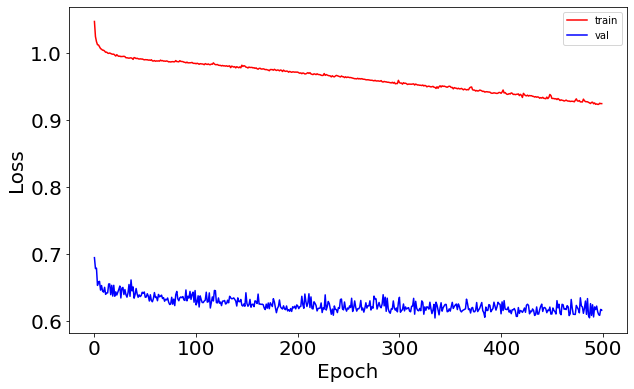

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(model_history.history['loss'], 'r', label='train')
ax.plot(model_history.history['val_loss'], 'b', label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [12]:
y_hat = model.predict(x_train)
R2_score = r2_score(y_train, y_hat)

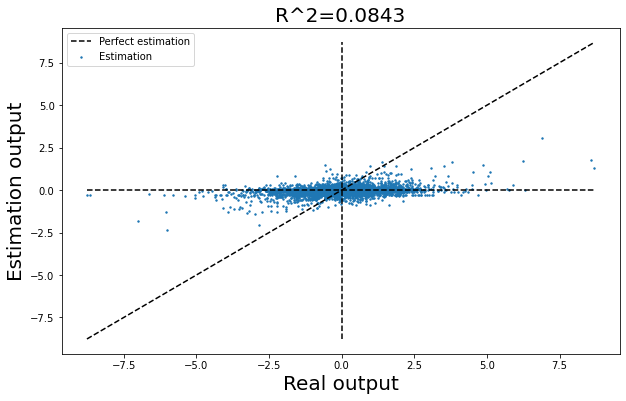

In [13]:
x_min, x_max = min(y_train), max(y_train)
x_line = np.linspace(x_min, x_max)

fig = plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_hat, s=2, label='Estimation')
plt.plot(x_line, x_line, 'k--', label='Perfect estimation')
plt.plot(x_line, 0*x_line, 'k--')
plt.plot(0*x_line, x_line, 'k--')
plt.xlabel('Real output', fontsize=20)
plt.ylabel('Estimation output', fontsize=20)
plt.title('R^2=%0.4f' % R2_score, fontsize=20)
plt.legend()
plt.show()

In [29]:
# BACKTEST (check if you're using val_x or x_train)
operations = fn.backtest(df=df, x_train=val_x, y_hat=model.predict(val_x), trading_volume=100000, capital=100000)
operations.head()

,signal,open,close,profit,cum_profit
date,,,,,
2021-04-27 01:00:00,1,1.20693,1.20728,35.0,100035.0
2021-04-27 02:00:00,0,1.20730,1.20756,-26.0,100009.0
2021-04-27 03:00:00,0,1.20756,1.20698,58.0,100067.0
2021-04-27 04:00:00,0,1.20698,1.20702,-4.0,100063.0
2021-04-27 05:00:00,0,1.20701,1.20583,118.0,100181.0


In [30]:
df_estadisticas_mad = fn.f_estadisticas_mad(df_evolucion_capital=operations)
df_estadisticas_mad

,metrica,tipo,valor,descripcion
0,sharpe_original,Cantidad,0.210707,Sharpe Ratio FÃ³rmula Original
1,drawdown_capi,Fecha Inicial,2021-04-28 12:00:00,Fecha inicial del DrawDown de Capital
2,drawdown_capi,Fecha Final,2021-04-28 15:00:00,Fecha final del DrawDown de Capital
3,drawdown_capi,DrawDown $ (capital),407,MÃ¡xima pÃ©rdida flotante registrada
4,drawup_capi,Fecha Inicial,2021-04-27 02:00:00,Fecha inicial del DrawUp de Capital
5,drawup_capi,Fecha Final,2021-04-29 07:00:00,Fecha final del DrawUp de Capital
6,drawup_capi,DrawUP $ (capital),1324,MÃ¡xima ganancia flotante registrada


In [31]:
df_estadisticas_ops = fn.f_estadisticas_ba(param_data=operations)
df_estadisticas_ops

,medida,valor,descripcion
0,Ops totales,66,Operaciones totales
1,Ganadoras,45,Operaciones ganadoras
2,Ganadoras_c,24,Operaciones ganadoras de compra
3,Ganadoras_v,21,Operaciones ganadoras de venta
4,Perdedoras,19,Operaciones perdedoras
5,Perdedoras_c,5,Operaciones perdedoras de compra
6,Perdedoras_v,14,Operaciones perdedoras de venta
7,Mediana (Profit),30.5,Mediana de profit de operaciones
9,r_efectividad,0.681818,Ganadoras Totales/Operaciones Totales
10,r_proporcion,2.36842,Ganadoras Totales/Perdedoras Totales


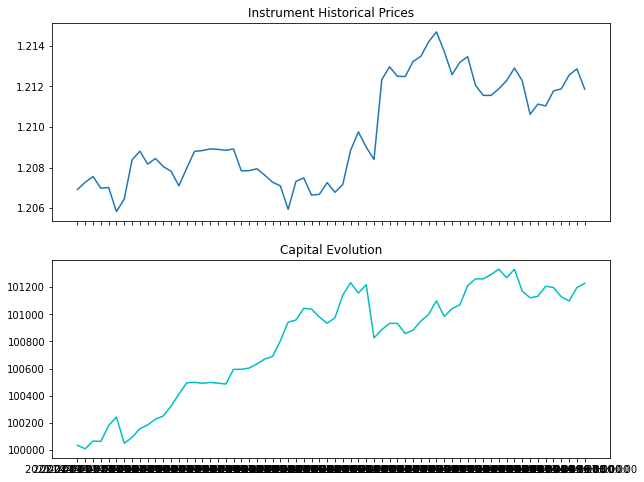

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
ax1.plot(df.set_index('timestamp').close[operations.index])
ax1.set_title('Instrument Historical Prices')
ax2.plot(operations.cum_profit, 'c-')
ax2.set_title('Capital Evolution')
plt.show()